# PPO & A2C for Stock Trading

In [1]:
pip install yfinance



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# ✅ STEP 1: Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

import warnings
warnings.filterwarnings('ignore')


In [6]:
# ✅ STEP 3: Combine into a DataFrame
df_list = []
for ticker in tickers:
    s = data[ticker]['Close']   # ✅ inside the for loop → indented
    s.name = ticker             # ✅ inside the for loop
    df_list.append(s)           # ✅ inside the for loop

df_combined = pd.concat(df_list, axis=1)
df_combined.dropna(inplace=True)

print("\n✅ Combined DataFrame Head:")
print(df_combined.head())



✅ Combined DataFrame Head:
Ticker            AAPL       GOOGL        AMZN        MSFT
Date                                                      
2024-11-01  222.420486  170.897079  197.929993  408.730652
2024-11-04  221.522446  168.851791  195.779999  406.828278
2024-11-05  222.959290  169.350662  199.500000  409.816315
2024-11-06  222.230896  176.105118  207.089996  418.501465
2024-11-07  226.980438  180.335403  210.050003  423.730530


In [8]:
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)[['Close']].dropna()
    data[ticker] = df

df_list = []
for ticker in tickers:
    s = data[ticker]['Close']
    s.name = ticker
    df_list.append(s)

df_combined = pd.concat(df_list, axis=1)
df_combined.dropna(inplace=True)

print("\n✅ Combined DataFrame Head:")
print(df_combined.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Combined DataFrame Head:
Ticker            AAPL       GOOGL        AMZN        MSFT
Date                                                      
2024-11-01  222.420486  170.897079  197.929993  408.730652
2024-11-04  221.522446  168.851791  195.779999  406.828278
2024-11-05  222.959290  169.350662  199.500000  409.816315
2024-11-06  222.230896  176.105118  207.089996  418.501465
2024-11-07  226.980438  180.335403  210.050003  423.730530


In [10]:
class MultiStockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(MultiStockTradingEnv, self).__init__()
        
        self.df = df.reset_index(drop=True)
        self.n_stocks = df.shape[1]
        self.initial_balance = initial_balance
        
        self.action_space = spaces.Discrete(3 ** self.n_stocks)  # Flatten MultiDiscrete
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1 + self.n_stocks*2,), dtype=np.float32)
        
        self.reset()
    
    def decode_action(self, action):
        multi_action = []
        for _ in range(self.n_stocks):
            multi_action.append(action % 3)
            action //= 3
        return multi_action[::-1]
    
    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = np.zeros(self.n_stocks)
        self.current_step = 0
        self.total_asset = self.balance
        return self._get_observation()
    
    def _get_observation(self):
        prices = self.df.iloc[self.current_step].values
        obs = np.concatenate(([self.balance], prices, self.shares_held))
        return obs
    
    def step(self, action):  # Note: single integer action
        actions = self.decode_action(action)
        prices = self.df.iloc[self.current_step].values
        
        for i, act in enumerate(actions):
            if act == 1:  # buy
                max_shares = self.balance // prices[i]
                if max_shares > 0:
                    self.shares_held[i] += max_shares
                    self.balance -= prices[i] * max_shares
            elif act == 2:  # sell
                self.balance += prices[i] * self.shares_held[i]
                self.shares_held[i] = 0
        
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        portfolio_value = self.balance + np.sum(self.shares_held * prices)
        reward = portfolio_value - self.total_asset
        self.total_asset = portfolio_value
        
        obs = self._get_observation()
        return obs, reward, done, {}


In [11]:
# ✅ STEP 5: Wrap environment for stable-baselines3
env = DummyVecEnv([lambda: MultiStockTradingEnv(df_combined)])

In [12]:
# ✅ STEP 6: Train PPO
print("\n✅ Training PPO...")
ppo_model = PPO('MlpPolicy', env, verbose=1)
ppo_model.learn(total_timesteps=10000)


✅ Training PPO...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 4747 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3566         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0028348225 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.39        |
|    explained_variance   | 7.44e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.05e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.012       |
|    value_loss           | 2.67e+05     |
-----------------------

In [13]:
# ✅ STEP 7: Train DQN
print("\n✅ Training DQN...")
dqn_model = DQN('MlpPolicy', env, verbose=1)
dqn_model.learn(total_timesteps=10000)


✅ Training DQN...
Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4025     |
|    time_elapsed     | 0        |
|    total_timesteps  | 488      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 198      |
|    n_updates        | 96       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.0728   |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4167     |
|    time_elapsed     | 0        |
|    total_timesteps  | 976      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 138      |
|    n_updates        | 218      |
----------------------------------
----------------------------------
| rollout/         

In [14]:
# ✅ STEP 8: Evaluate models
ppo_reward, _ = evaluate_policy(ppo_model, env, n_eval_episodes=1, return_episode_rewards=True)
dqn_reward, _ = evaluate_policy(dqn_model, env, n_eval_episodes=1, return_episode_rewards=True)

print(f"\n✅ PPO Cumulative Reward: {ppo_reward}")
print(f"✅ DQN Cumulative Reward: {dqn_reward}")


✅ PPO Cumulative Reward: [-630.1448669433594]
✅ DQN Cumulative Reward: [0.0]


In [15]:
# ✅ STEP 9: Buy & Hold Baseline
initial_prices = df_combined.iloc[0].values
final_prices = df_combined.iloc[-1].values
shares_per_stock = (10000 / len(tickers)) / initial_prices
buy_and_hold_value = np.sum(shares_per_stock * final_prices)

print(f"✅ Buy and Hold Final Portfolio Value: {buy_and_hold_value}")

✅ Buy and Hold Final Portfolio Value: 9761.640748736045


In [16]:
# ✅ STEP 10: Run environment with trained PPO → collect portfolio values
ppo_env = MultiStockTradingEnv(df_combined)
obs = ppo_env.reset()
ppo_portfolio_values = [ppo_env.total_asset]

for _ in range(len(df_combined)-1):
    action, _states = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, info = ppo_env.step(action)
    ppo_portfolio_values.append(ppo_env.total_asset)
    if done:
        break

In [17]:
# ✅ STEP 11: Run environment with trained DQN → collect portfolio values
dqn_env = MultiStockTradingEnv(df_combined)
obs = dqn_env.reset()
dqn_portfolio_values = [dqn_env.total_asset]

for _ in range(len(df_combined)-1):
    action, _states = dqn_model.predict(obs, deterministic=True)
    obs, reward, done, info = dqn_env.step(action)
    dqn_portfolio_values.append(dqn_env.total_asset)
    if done:
        break

In [18]:
# ✅ STEP 12: Calculate buy and hold portfolio value over time
initial_prices = df_combined.iloc[0].values
shares_per_stock = (10000 / len(tickers)) / initial_prices
buy_hold_values = []

for i in range(len(df_combined)):
    prices = df_combined.iloc[i].values
    value = np.sum(shares_per_stock * prices)
    buy_hold_values.append(value)

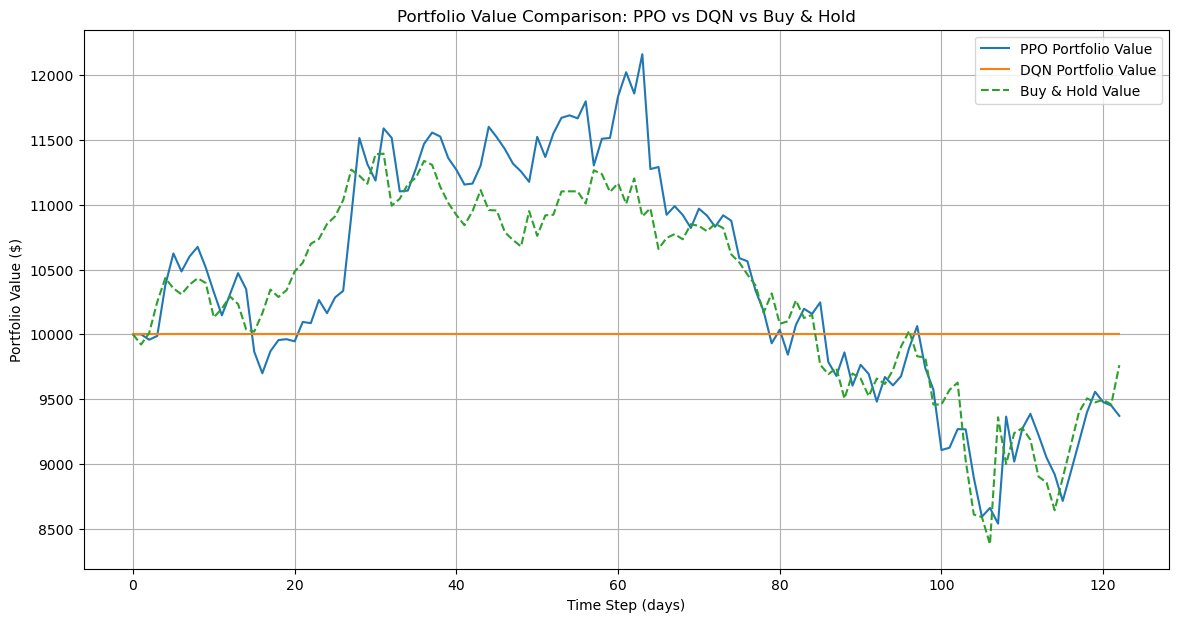

In [19]:
# ✅ STEP 13: Plot
plt.figure(figsize=(14,7))
plt.plot(ppo_portfolio_values, label='PPO Portfolio Value')
plt.plot(dqn_portfolio_values, label='DQN Portfolio Value')
plt.plot(buy_hold_values, label='Buy & Hold Value', linestyle='--')

plt.xlabel('Time Step (days)')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Comparison: PPO vs DQN vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# ✅ STEP 14: Cumulative Return Plot
ppo_return = (ppo_portfolio_values[-1] - 10000) / 10000 * 100
dqn_return = (dqn_portfolio_values[-1] - 10000) / 10000 * 100
buy_hold_return = (buy_hold_values[-1] - 10000) / 10000 * 100

print(f"\n✅ PPO Cumulative Return: {ppo_return:.2f}%")
print(f"✅ DQN Cumulative Return: {dqn_return:.2f}%")
print(f"✅ Buy & Hold Cumulative Return: {buy_hold_return:.2f}%")


✅ PPO Cumulative Return: -6.30%
✅ DQN Cumulative Return: 0.00%
✅ Buy & Hold Cumulative Return: -2.38%


In [21]:
from stable_baselines3 import A2C

# ✅ Train PPO longer for better learning
print("\n✅ Training PPO (50k timesteps)...")
ppo_model = PPO('MlpPolicy', env, verbose=1)
ppo_model.learn(total_timesteps=50000)

# ✅ Train A2C
print("\n✅ Training A2C (50k timesteps)...")
a2c_model = A2C('MlpPolicy', env, verbose=1)
a2c_model.learn(total_timesteps=50000)



✅ Training PPO (50k timesteps)...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 4802 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3455         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024588597 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.39        |
|    explained_variance   | 0.00022      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.17e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00969     |
|    value_loss           | 2.7e+05      |
-------

In [22]:
#Evaluate PPO & A2C portfolio values:
# ✅ Run PPO
ppo_env = MultiStockTradingEnv(df_combined)
obs = ppo_env.reset()
ppo_portfolio_values = [ppo_env.total_asset]
for _ in range(len(df_combined)-1):
    action, _states = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, info = ppo_env.step(action)
    ppo_portfolio_values.append(ppo_env.total_asset)
    if done:
        break

# ✅ Run A2C
a2c_env = MultiStockTradingEnv(df_combined)
obs = a2c_env.reset()
a2c_portfolio_values = [a2c_env.total_asset]
for _ in range(len(df_combined)-1):
    action, _states = a2c_model.predict(obs, deterministic=True)
    obs, reward, done, info = a2c_env.step(action)
    a2c_portfolio_values.append(a2c_env.total_asset)
    if done:
        break

# ✅ Buy & Hold baseline
initial_prices = df_combined.iloc[0].values
shares_per_stock = (10000 / len(tickers)) / initial_prices
buy_hold_values = []
for i in range(len(df_combined)):
    prices = df_combined.iloc[i].values
    value = np.sum(shares_per_stock * prices)
    buy_hold_values.append(value)


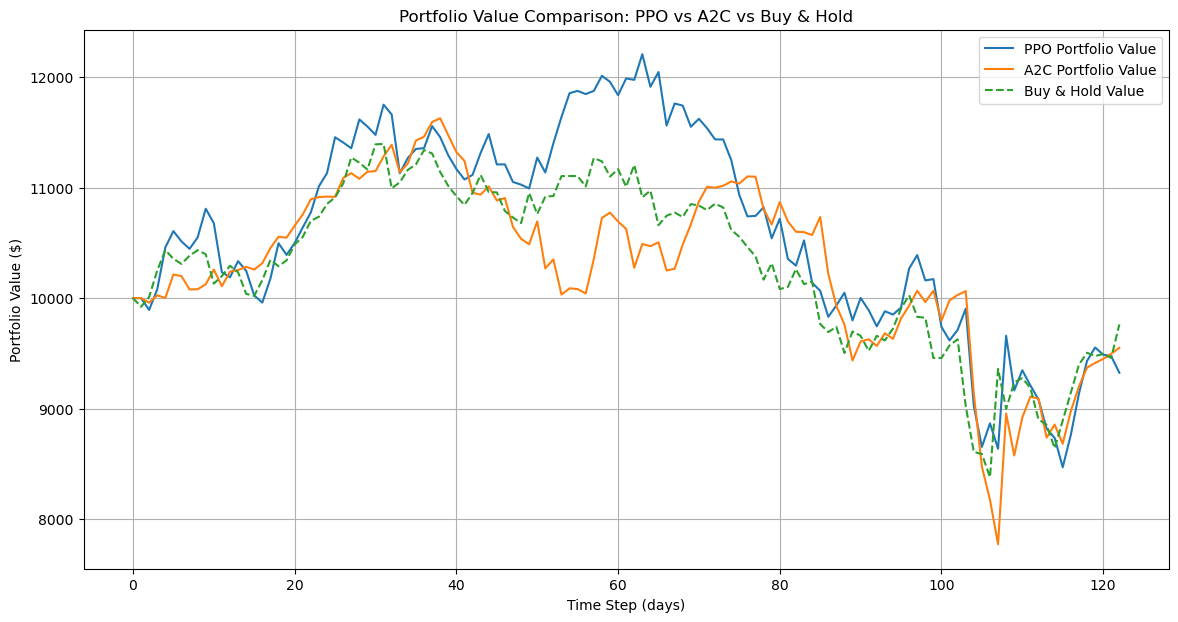


✅ PPO Cumulative Return: -6.75%
✅ A2C Cumulative Return: -4.50%
✅ Buy & Hold Cumulative Return: -2.38%


In [23]:
plt.figure(figsize=(14,7))
plt.plot(ppo_portfolio_values, label='PPO Portfolio Value')
plt.plot(a2c_portfolio_values, label='A2C Portfolio Value')
plt.plot(buy_hold_values, label='Buy & Hold Value', linestyle='--')

plt.xlabel('Time Step (days)')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Comparison: PPO vs A2C vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print cumulative returns
ppo_return = (ppo_portfolio_values[-1] - 10000) / 10000 * 100
a2c_return = (a2c_portfolio_values[-1] - 10000) / 10000 * 100
buy_hold_return = (buy_hold_values[-1] - 10000) / 10000 * 100

print(f"\n✅ PPO Cumulative Return: {ppo_return:.2f}%")
print(f"✅ A2C Cumulative Return: {a2c_return:.2f}%")
print(f"✅ Buy & Hold Cumulative Return: {buy_hold_return:.2f}%")


In [24]:
#better results
ppo_model.learn(total_timesteps=100000)
a2c_model.learn(total_timesteps=100000)


-----------------------------
| time/              |      |
|    fps             | 3629 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 2909          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 8.3469786e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.39         |
|    explained_variance   | 0.0659        |
|    learning_rate        | 0.0003        |
|    loss                 | 1.39e+05      |
|    n_updates            | 260           |
|    policy_gradient_loss | -4.67e-05     |
|    value_loss           | 2.9e+05       |
------------------------------------------

In [29]:
class MultiStockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000, transaction_cost_pct=0.001):
        super(MultiStockTradingEnv, self).__init__()
        
        self.df = df.reset_index(drop=True)
        self.tickers = [col for col in df.columns if not any(x in col for x in ['SMA', 'Volatility'])]
        self.n_stocks = len(self.tickers)
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost_pct
        
        # Action space: 0=hold, 1=buy, 2=sell per stock
        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)
        
        # Observation: balance + prices + SMA + Volatility + holdings
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1 + self.n_stocks * 4,), dtype=np.float32)
        
        self.reset()
    
    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = np.zeros(self.n_stocks)
        self.current_step = 0
        self.total_asset = self.balance
        return self._get_observation()
    
    def _get_observation(self):
        prices = self.df[self.tickers].iloc[self.current_step].values
        smas = self.df[[f"{t}_SMA" for t in self.tickers]].iloc[self.current_step].values
        vols = self.df[[f"{t}_Volatility" for t in self.tickers]].iloc[self.current_step].values
        obs = np.concatenate(([self.balance], prices, smas, vols, self.shares_held))
        return obs
    
    def step(self, actions):
        prices = self.df[self.tickers].iloc[self.current_step].values
        
        total_transaction_cost = 0
        for i, action in enumerate(actions):
            if action == 1:  # Buy
                max_shares = self.balance // prices[i]
                if max_shares > 0:
                    cost = prices[i] * max_shares * self.transaction_cost_pct
                    self.shares_held[i] += max_shares
                    self.balance -= prices[i] * max_shares + cost
                    total_transaction_cost += cost
            elif action == 2:  # Sell
                if self.shares_held[i] > 0:
                    cost = prices[i] * self.shares_held[i] * self.transaction_cost_pct
                    self.balance += prices[i] * self.shares_held[i] - cost
                    total_transaction_cost += cost
                    self.shares_held[i] = 0
        
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        portfolio_value = self.balance + np.sum(self.shares_held * prices)
        
        # Normalized reward
        reward = (portfolio_value - self.total_asset) / self.total_asset
        # Apply transaction cost penalty
        reward -= total_transaction_cost / self.total_asset
        
        self.total_asset = portfolio_value
        
        obs = self._get_observation()
        return obs, reward, done, {}
    
    def render(self, mode='human'):
        prices = self.df[self.tickers].iloc[self.current_step].values
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance}")
        print(f"Shares held: {self.shares_held}")
        print(f"Prices: {prices}")
        print(f"Portfolio value: {self.total_asset}")


In [31]:
# ✅ Add SMA and Volatility columns to df_combined
for ticker in tickers:
    df_combined[f"{ticker}_SMA"] = df_combined[ticker].rolling(window=5).mean()
    df_combined[f"{ticker}_Volatility"] = df_combined[ticker].rolling(window=5).std()

# ✅ Drop rows with NaNs from rolling
df_combined.dropna(inplace=True)

print(df_combined.head())  # confirm columns exist


Ticker            AAPL       GOOGL        AMZN        MSFT    AAPL_SMA  \
Date                                                                     
2024-11-07  226.980438  180.335403  210.050003  423.730530  223.222711   
2024-11-08  226.710739  177.940903  208.179993  420.852051  224.080762   
2024-11-11  223.983734  179.936325  206.839996  416.340149  224.573019   
2024-11-12  223.983734  181.203384  208.910004  421.340088  224.777908   
2024-11-13  224.872757  178.469696  214.100006  423.501465  225.306281   

Ticker      AAPL_Volatility   GOOGL_SMA  GOOGL_Volatility    AMZN_SMA  \
Date                                                                    
2024-11-07         2.162641  173.108011          4.958305  202.069998   
2024-11-08         2.576315  174.516776          5.169252  204.119998   
2024-11-11         2.168089  176.733682          4.460683  206.331998   
2024-11-12         2.020870  179.104227          2.059285  208.213998   
2024-11-13         1.454434  179.577142    

In [33]:
# ✅ Add SMA & Volatility columns
for ticker in tickers:
    df_combined[f"{ticker}_SMA"] = df_combined[ticker].rolling(window=5).mean()
    df_combined[f"{ticker}_Volatility"] = df_combined[ticker].rolling(window=5).std()

df_combined.dropna(inplace=True)

print(df_combined.columns)


Index(['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'AAPL_SMA', 'AAPL_Volatility',
       'GOOGL_SMA', 'GOOGL_Volatility', 'AMZN_SMA', 'AMZN_Volatility',
       'MSFT_SMA', 'MSFT_Volatility'],
      dtype='object', name='Ticker')


In [32]:
#trained models with ppo and a2c with imorovede environment
from stable_baselines3 import PPO, A2C

# ✅ Create environment
env = DummyVecEnv([lambda: MultiStockTradingEnv(df_combined)])

# ✅ Train PPO
print("\n✅ Training PPO (100k timesteps)...")
ppo_model = PPO('MlpPolicy', env, verbose=1)
ppo_model.learn(total_timesteps=100000)

# ✅ Train A2C
print("\n✅ Training A2C (100k timesteps)...")
a2c_model = A2C('MlpPolicy', env, verbose=1)
a2c_model.learn(total_timesteps=100000)



✅ Training PPO (100k timesteps)...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1291 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1138        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015254216 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.38       |
|    explained_variance   | -1.35       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00484     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00984    |
|    value_loss           | 0.0339      |
-----------------------

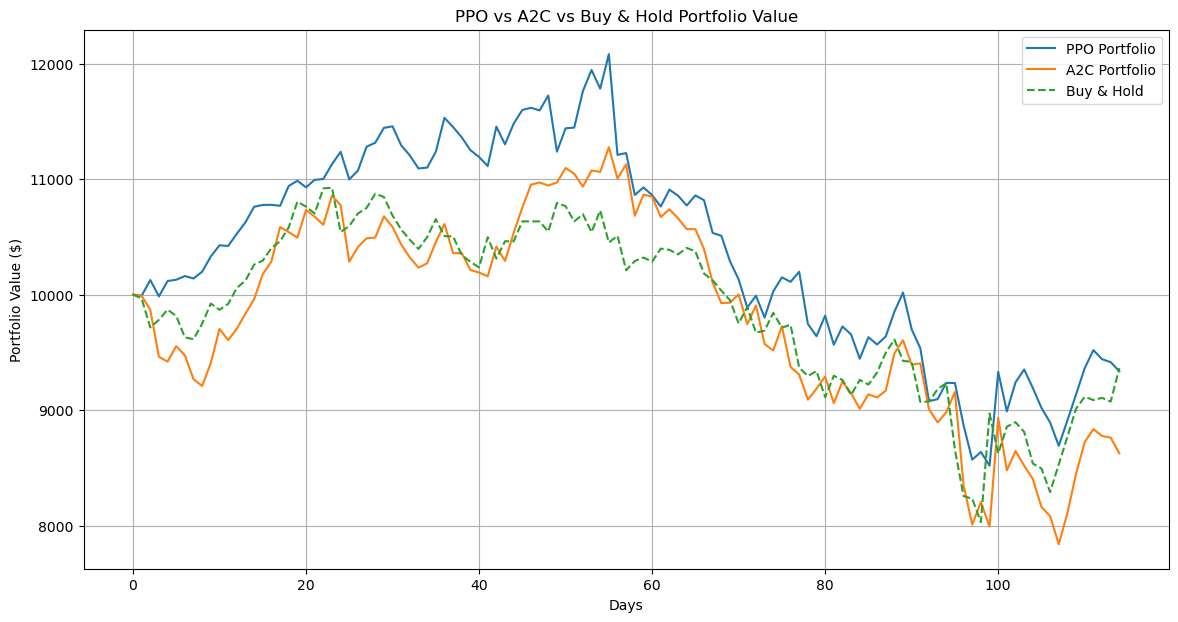

✅ PPO Return: -6.64%
✅ A2C Return: -13.75%
✅ Buy & Hold Return: -6.37%


In [34]:
# ✅ Evaluate PPO
ppo_env = MultiStockTradingEnv(df_combined)
obs = ppo_env.reset()
ppo_values = [ppo_env.total_asset]
for _ in range(len(df_combined)-1):
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, _ = ppo_env.step(action)
    ppo_values.append(ppo_env.total_asset)
    if done: break

# ✅ Evaluate A2C
a2c_env = MultiStockTradingEnv(df_combined)
obs = a2c_env.reset()
a2c_values = [a2c_env.total_asset]
for _ in range(len(df_combined)-1):
    action, _ = a2c_model.predict(obs, deterministic=True)
    obs, reward, done, _ = a2c_env.step(action)
    a2c_values.append(a2c_env.total_asset)
    if done: break

# ✅ Buy & Hold baseline
initial_prices = df_combined.iloc[0][tickers].values
shares = (10000 / len(tickers)) / initial_prices
buy_hold = []
for i in range(len(df_combined)):
    prices = df_combined.iloc[i][tickers].values
    value = np.sum(shares * prices)
    buy_hold.append(value)

# ✅ Plot
plt.figure(figsize=(14, 7))
plt.plot(ppo_values, label='PPO Portfolio')
plt.plot(a2c_values, label='A2C Portfolio')
plt.plot(buy_hold, label='Buy & Hold', linestyle='--')
plt.title('PPO vs A2C vs Buy & Hold Portfolio Value')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Cumulative returns
ppo_return = (ppo_values[-1] - 10000) / 10000 * 100
a2c_return = (a2c_values[-1] - 10000) / 10000 * 100
buy_return = (buy_hold[-1] - 10000) / 10000 * 100

print(f"✅ PPO Return: {ppo_return:.2f}%")
print(f"✅ A2C Return: {a2c_return:.2f}%")
print(f"✅ Buy & Hold Return: {buy_return:.2f}%")


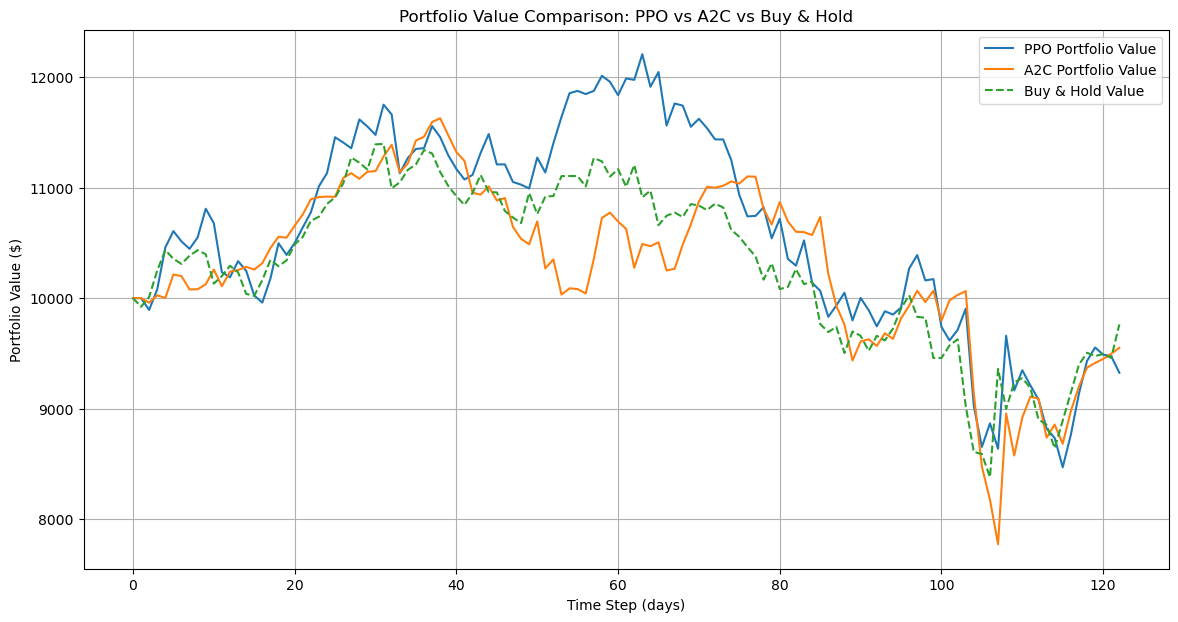


✅ PPO Cumulative Return: -6.75%
✅ A2C Cumulative Return: -4.50%
✅ Buy & Hold Cumulative Return: -2.38%


In [35]:
# above or prefer below reference
# ✅ Plot results
plt.figure(figsize=(14,7))
plt.plot(ppo_portfolio_values, label='PPO Portfolio Value')
plt.plot(a2c_portfolio_values, label='A2C Portfolio Value')
plt.plot(buy_hold_values, label='Buy & Hold Value', linestyle='--')

plt.xlabel('Time Step (days)')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Comparison: PPO vs A2C vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print cumulative returns
ppo_return = (ppo_portfolio_values[-1] - 10000) / 10000 * 100
a2c_return = (a2c_portfolio_values[-1] - 10000) / 10000 * 100
buy_hold_return = (buy_hold_values[-1] - 10000) / 10000 * 100

print(f"\n✅ PPO Cumulative Return: {ppo_return:.2f}%")
print(f"✅ A2C Cumulative Return: {a2c_return:.2f}%")
print(f"✅ Buy & Hold Cumulative Return: {buy_hold_return:.2f}%")


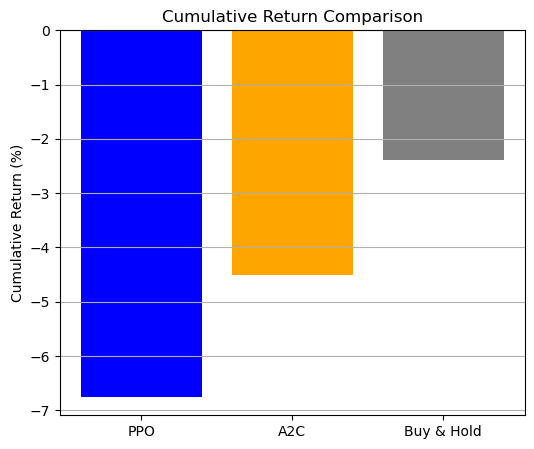

In [36]:
models = ['PPO', 'A2C', 'Buy & Hold']
returns = [ppo_return, a2c_return, buy_hold_return]

plt.figure(figsize=(6,5))
plt.bar(models, returns, color=['blue','orange','gray'])
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Comparison')
plt.grid(axis='y')
plt.show()


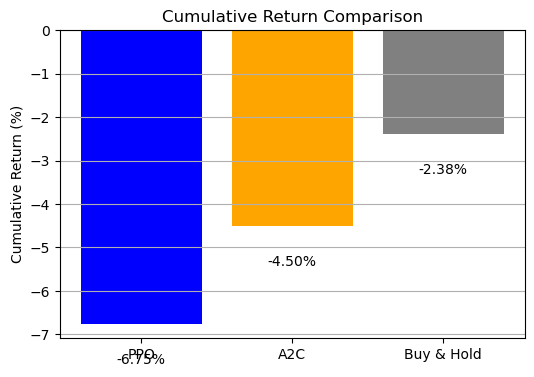

In [37]:
import matplotlib.pyplot as plt

models = ['PPO', 'A2C', 'Buy & Hold']
returns = [-6.75, -4.50, -2.38]

plt.figure(figsize=(6,4))
bars = plt.bar(models, returns, color=['blue', 'orange', 'gray'])
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Return Comparison')
plt.grid(axis='y')

# Add values on top
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()-1, f"{bar.get_height():.2f}%", ha='center', va='bottom')

plt.show()
